In [1]:
from glob import glob
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from tqdm import tqdm

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes
from lsst.ts.idl.enums import MTM1M3


from lsst.ts.ofc import BendModeToForce, OFCData

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

from scipy.interpolate import LinearNDInterpolator


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

FATABLE_INDEX = 0
FATABLE_ID = 1
FATABLE_XPOSITION = 2
FATABLE_YPOSITION = 3
FATABLE_ZPOSITION = 4
FATABLE_TYPE = 5
FATABLE_SUBNET = 6
FATABLE_ADDRESS = 7
FATABLE_ORIENTATION = 8
FATABLE_XINDEX = 9
FATABLE_YINDEX = 10
FATABLE_ZINDEX = 11
FATABLE_SINDEX = 12

from FATABLE import FATABLE as fatable

In [3]:
positions_frame=pd.DataFrame({"id":np.arange(156)})
positions_frame["x"]= [fatable[i][2] for i in np.arange(156)]
positions_frame["y"]= [fatable[i][3] for i in np.arange(156)]
positions_frame["z"]= [fatable[i][4] for i in np.arange(156)]

In [4]:
cols=[f"primaryCylinderFollowingError{i}" for i in np.arange(156)]
client = EfdClient('usdf_efd')
event_time=Time("2023-06-27 12:10:17.733")
df_m1m3_fa_0=getEfdData(client,"lsst.sal.MTM1M3.forceActuatorData",  columns=cols,
                           begin=event_time, end=event_time, prePadding=3, postPadding=4)

# example plot of actuators

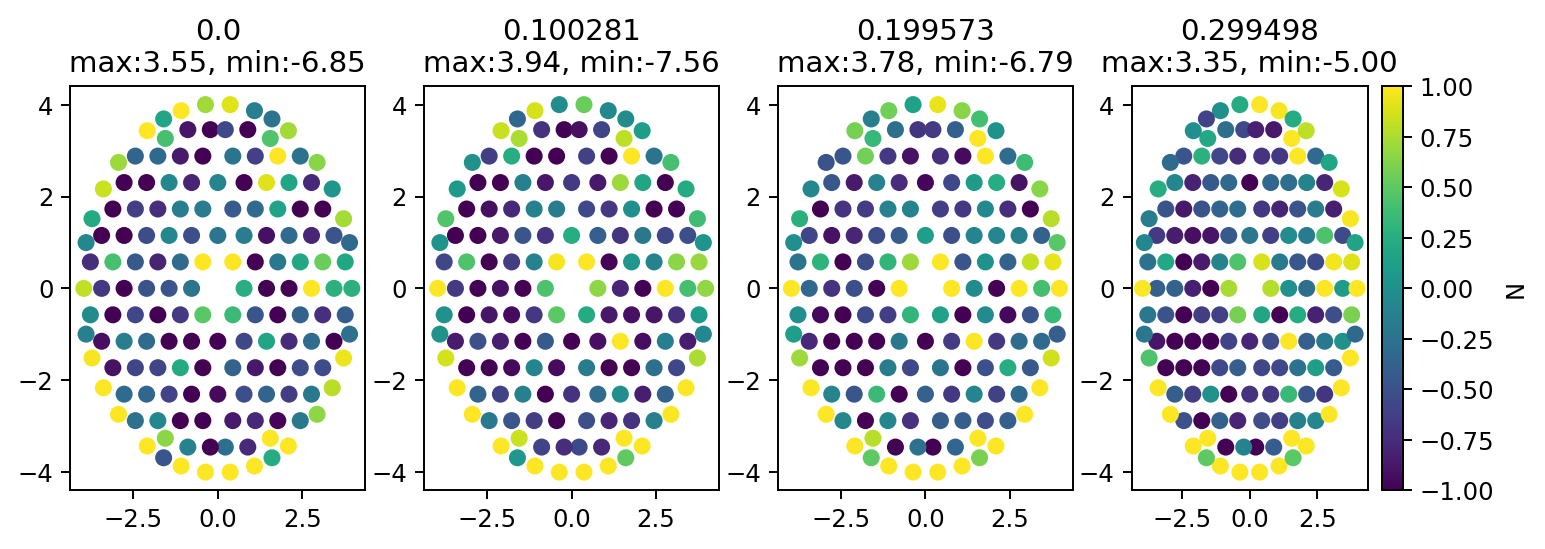

In [5]:
fig, axs=plt.subplots(1,4,dpi=175, figsize=(10,3))
for i,j in enumerate([0,5,10,15]):
    ax=axs[i]
    force0=df_m1m3_fa_0.iloc[j,:].values
    ax.set_title(f"{(df_m1m3_fa_0.index[j]-df_m1m3_fa_0.index[0]).total_seconds()}\nmax:{force0.max():0.2f}, min:{force0.min():0.2f}")
    
    _=ax.scatter(positions_frame["x"], positions_frame["y"], c=force0, vmin=-1, vmax=1)
plt.colorbar(_, label="N")

# bending mode stuff starts here

In [6]:

ofc_data = OFCData("lsst")
bmc=BendModeToForce( "M1M3",ofc_data )
m1m3_modes=np.loadtxt("/home/p/pferguso/u/repos/lsst_ts/ts_lsst_aos_phosim/data/M1M3/M1M3_1um_156_grid.DAT")

times=(df_m1m3_fa_0.index-df_m1m3_fa_0.index[0]).total_seconds().values
col_names=[f"mode_{i}" for i in np.arange(20)]

In [7]:
modes=bmc.bending_mode(df_m1m3_fa_0.iloc[i,:].values)
row_dict={}
for i in np.arange(20):
    row_dict[col_names[i]]=modes[i]

In [8]:
mode_list=[]
for i in range(len(df_m1m3_fa_0)):
    mode_list.append(bmc.bending_mode(df_m1m3_fa_0.iloc[i,:].values))

In [ ]:
mode_frame=pd.DataFrame(np.vstack(mode_list), columns=[f"mode_{i}" for i in np.arange(0,20)])

mode_names=[f"mode_{i}" for i in np.arange(1,21)]

In [ ]:
mode_frame

# Interpolated bending mode
- My column names are off 

In [ ]:
points=np.arange(0.95,5, 0.01)
#for i,point in tqdm(enumerate(points)):
i=0
point=points[0]
ind=np.argmin(abs(times-point))
x = m1m3_modes[:,1]
y = m1m3_modes[:,2]
z = mode_frame["mode_0"][ind] * m1m3_modes[:,3] 
z += mode_frame["mode_1"][ind] * m1m3_modes[:,4] 
z += mode_frame["mode_2"][ind] * m1m3_modes[:,5]
z += mode_frame["mode_3"][ind] * m1m3_modes[:,6]
num=300
X = np.linspace(min(x), max(x), num=num)
Y = np.linspace(min(y), max(y), num=num)
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = LinearNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.title(f"M1M3 hardpoint oscillation\nt={point-1:0.2f} s")
plt.xlabel("X")
plt.ylabel("Y")
plt.pcolormesh(X, Y, Z, shading='auto',vmax=2e-7,vmin=-2e-7)
plt.colorbar(label="m")
    
    # plt.savefig(f"../data/movie/bend_example_{i:04d}.png")
    # plt.close()

In [ ]:
plt.figure(dpi=175, figsize=(10,5))
for i, mode in enumerate(col_names):
    plt.plot(times, mode_frame[mode].values, label=mode_names[i])
plt.legend(ncol=4)
plt.xlabel("Time [s]")
plt.ylabel("estimated bending mode [$\mu$m]")

In [ ]:
def get_freq_psd(vals,timestep):
    meanval=np.mean(vals)
    signal= vals - meanval
    N=len(signal)
    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2
    frequencies = np.fft.rfftfreq(N, timestep)
    return(frequencies, psd)

fig, axs=plt.subplots(1, dpi=175, figsize=(6,5))
ax=axs
for i in np.arange(3):
    freq,psd=get_freq_psd(mode_frame[col_names[i]].values,0.02)
    psd=psd/np.median(psd)
    plt.plot(freq,psd, label=col_names[i])
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_xlim(-1,15)
ax.set_xticks(np.arange(15))
ax.set_xlabel("frequency (hz)")
ax.set_ylabel("relative power")